In [1]:
from langchain.chat_models import init_chat_model
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
# from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from dotenv import load_dotenv
import os 
from langchain.tools import tool



load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")
memory = MemorySaver()



In [27]:
class State(TypedDict):
    messages: Annotated[list,add_messages]
    
def get_stock_price(symbol:str)->float:
    '''Return the current price of a stock given the stock symbol
    :param symbol: stock symbol
    :return: current price of the stock
    '''
    return {
        "MSFT": 200.3,
        "AAPL": 100.4,
        "AMZN": 150.0,
        "RIL": 87.6
    }.get(symbol, 0.0)
    
tools = [get_stock_price]

llm = init_chat_model('gpt-4o-mini')
llm_with_tools = llm.bind_tools(tools)

def chatbot(state:State)-> str:
    return {"messages": [llm_with_tools.invoke(state["messages"])]}
    
    

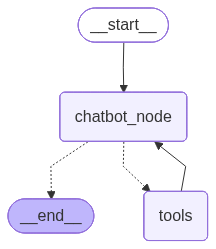

In [28]:
builder = StateGraph(State)
builder.add_node('chatbot_node',chatbot)
builder.add_node('tools', ToolNode(tools))

builder.add_edge(START, 'chatbot_node')
builder.add_conditional_edges('chatbot_node', tools_condition)
builder.add_edge('tools', 'chatbot_node')
builder.add_edge( 'chatbot_node', END) 

graph=builder.compile(checkpointer=memory)
graph

In [29]:
config1 = {'configurable': {'thread_id':'1'}}
msg = "I want to buy 20 AMZN stocks using current price. Then 15 MSFT. What will be the total cost?"
state = graph.invoke({'messages':[{'role':'user','content':msg}]},config=config1)
print(state["messages"][-1].content)


The current prices are as follows:
- Amazon (AMZN): $150.00
- Microsoft (MSFT): $200.30

To calculate the total cost:
- For 20 AMZN stocks: \( 20 \times 150 = 3000 \)
- For 15 MSFT stocks: \( 15 \times 200.30 = 3004.5 \)

Now, adding both amounts:
- Total cost = \( 3000 + 3004.5 = 6004.5 \)

Therefore, the total cost will be **$6004.50**.


In [30]:

msg = "Using the current price tell me the total price of 10 RIL stocks and add it to previous total cost"

state = graph.invoke({"messages": [{"role": "user", "content": msg}]}, config=config1)
print(state["messages"][-1].content)

The current price of Reliance Industries Limited (RIL) is $87.60.

To calculate the total cost for 10 RIL stocks:
- For 10 RIL stocks: \( 10 \times 87.6 = 876 \)

Now, adding this to the previous total cost of $6004.50:
- New total cost = \( 6004.5 + 876 = 6880.5 \)

Thus, the updated total cost will be **$6880.50**.
